In [1]:
import sys
import os
import json
import regex as re
import numpy as np

In [2]:
def random_instructions(filename, size):
    with open(filename) as f:
        if filename.endswith('jsonl'):
            data = []
            for line in f:
                data.append(json.loads(line.strip()))
        else:
            data = json.load(f)
    
    np.random.seed(42)
    samples = np.random.choice(data, size=size, replace=False)
    instructions = []
    for sample in samples:
        if 'alpaca' in filename:
            instruction = sample['instruction'].split('Your code should pass')[0].strip()
        elif 'synthesized' in filename:
            instruction = sample['original_instruction']
        
        instruction_split = re.split('^Write[^,.]+to', instruction)
        if len(instruction_split) > 1:
            instruction = instruction_split[1].strip()
        
        instructions.append(instruction)
        
    return instructions

In [3]:
from itertools import combinations

def gen_cand_ref(instructions):
    cands, refs = zip(*combinations(instructions, 2))
    
    np.random.seed(42)
    indices = np.random.choice(len(cands), size=min(10000, len(cands)), replace=False)
    cands = [cands[idx] for idx in indices]
    refs = [refs[idx] for idx in indices]
    return cands, refs

In [4]:
import logging
import transformers
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)

from bert_score import score

def compute_simscore(cands, refs):
    P, R, F1 = score(cands, refs, lang='en', verbose=True, rescale_with_baseline=True)
    return P, R, F1


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/wangqianle/miniconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/wangqianle/miniconda3/envs/llm/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/wangqianle/miniconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


In [5]:
def F1_score(filename, size=400):
    instructions = random_instructions(filename, size=size)
    cands, refs = gen_cand_ref(instructions)
    P, R, F1 = compute_simscore(cands, refs)
    return F1

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [7]:
alpaca_F1 = F1_score('../../data/alpaca/mbpp_alpaca_1k.jsonl')
print("\nF1 mean:", alpaca_F1.mean().item())

calculating scores...
computing bert embedding.


  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/157 [00:00<?, ?it/s]

done in 2.71 seconds, 3696.14 sentences/sec

F1 mean: 0.18211761116981506


In [8]:
syn_F1 = F1_score('../../data/ada-instruct/mbpp_synthesized_10k.jsonl')
print("\nF1 mean:", syn_F1.mean().item())

calculating scores...
computing bert embedding.


  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/157 [00:00<?, ?it/s]

done in 2.91 seconds, 3433.81 sentences/sec

F1 mean: 0.029133547097444534


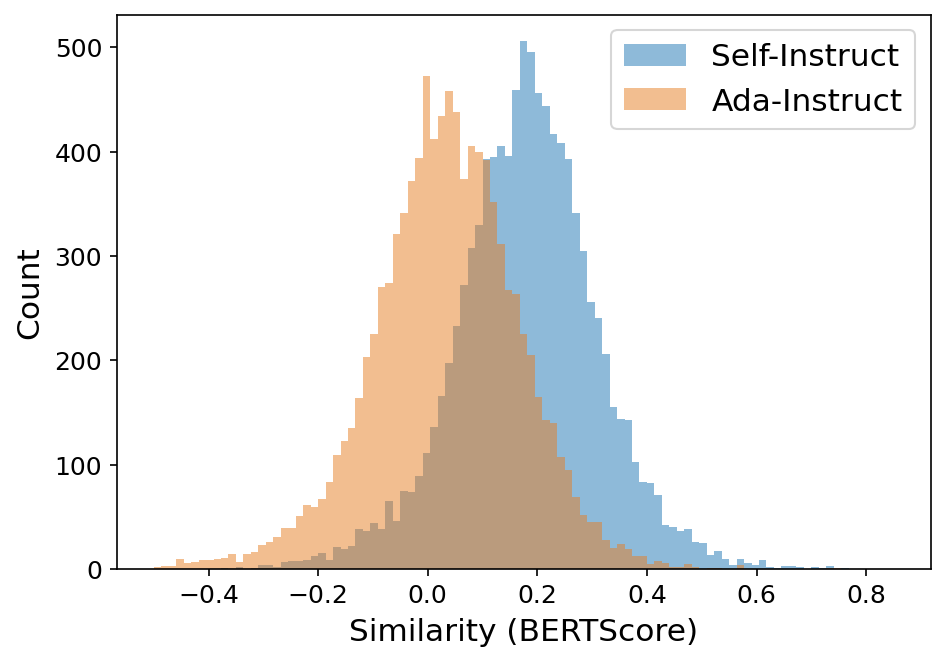

In [9]:
bins = np.linspace(-0.5, 0.85, 100)
fig = plt.figure(figsize=(7.0, 4.8), dpi=150)
plt.hist(alpaca_F1, bins, alpha=0.5, label='Self-Instruct', color='#1f77b4')
plt.hist(syn_F1, bins, alpha=0.5, label='Ada-Instruct', color='#e67e22')
plt.tick_params(labelsize=12)
plt.xlabel("Similarity (BERTScore)", fontdict={'size': 15}, labelpad=5)
plt.ylabel("Count", fontdict={'size': 15}, labelpad=5)
plt.legend(loc='upper right', prop={'size': 15})
plt.show()